In [1]:
'''
!pip install scikit-image
!pip install scikit-learn
!pip install opencv-python
!pip install opencv-contrib-python
!pip install numpy
!pip install matplotlib
'''

'\n!pip install scikit-image\n!pip install scikit-learn\n!pip install opencv-python\n!pip install opencv-contrib-python\n!pip install numpy\n!pip install matplotlib\n'

In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Prepare image data

In [3]:
!git clone https://github.com/folfcoder/recaptcha-dataset.git

Cloning into 'recaptcha-dataset'...
remote: Enumerating objects: 11754, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 11754 (delta 5), reused 1 (delta 0), pack-reused 11742
Receiving objects: 100% (11754/11754), 395.64 MiB | 13.00 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (11779/11779), done.


### Preprocessing

In [4]:
image_path = './recaptcha-dataset/Large/Bicycle/Bicycle (3).png'

# point processing
# load BGR image
image = cv2.imread(image_path)

# BGR -> gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# BGR -> HSV
hsi = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# gray -> contrast stretching
# 어둡든, 밝든 비슷한 intensity의 이미지로 변환됨
stretch = cv2.equalizeHist(gray)

# area processing
# noise filtering
blur_gauss = cv2.GaussianBlur(image, ksize=(3, 3), sigmaX=1)
blur_median = cv2.medianBlur(image, ksize=3)
blur_mean = cv2.blur(image, ksize=(3, 3))

# edge
edge_canny = cv2.Canny(gray, 100, 200)
edge_sobelx = cv2.Sobel(gray, ddepth=-1, dx=1, dy=0, delta=128)
edge_sobely = cv2.Sobel(gray, ddepth=-1, dx=0, dy=1, delta=128)

# sharpening(high boost filtering)
sharp = cv2.addWeighted(image, 2, blur_gauss, -1, 0)

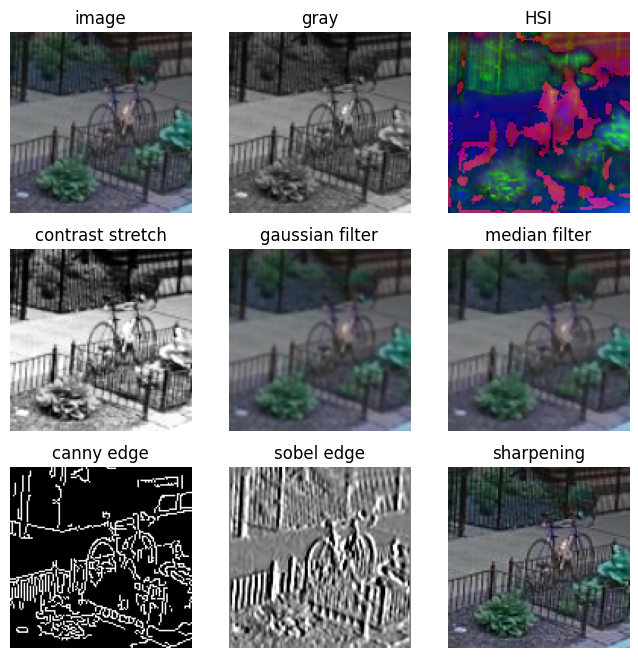

In [5]:
# visualization
plt.figure(figsize=(8, 8))

plt.subplot(3, 3, 1)
plt.title('image')
plt.axis('off')
plt.imshow(image)

plt.subplot(3, 3, 2)
plt.title('gray')
plt.axis('off')
plt.imshow(gray, cmap='gray')

plt.subplot(3, 3, 3)
plt.title('HSI')
plt.axis('off')
plt.imshow(hsi)

plt.subplot(3, 3, 4)
plt.title('contrast stretch')
plt.axis('off')
plt.imshow(stretch, cmap='gray')

plt.subplot(3, 3, 5)
plt.title('gaussian filter')
plt.axis('off')
plt.imshow(blur_gauss)

plt.subplot(3, 3, 6)
plt.title('median filter')
plt.axis('off')
plt.imshow(blur_median)

plt.subplot(3, 3, 7)
plt.title('canny edge')
plt.axis('off')
plt.imshow(edge_canny, cmap='gray')

plt.subplot(3, 3, 8)
plt.title('sobel edge')
plt.axis('off')
plt.imshow(edge_sobelx, cmap='gray')

plt.subplot(3, 3, 9)
plt.title('sharpening')
plt.axis('off')
plt.imshow(sharp)

## Feature extraction
### histogram

<BarContainer object of 128 artists>

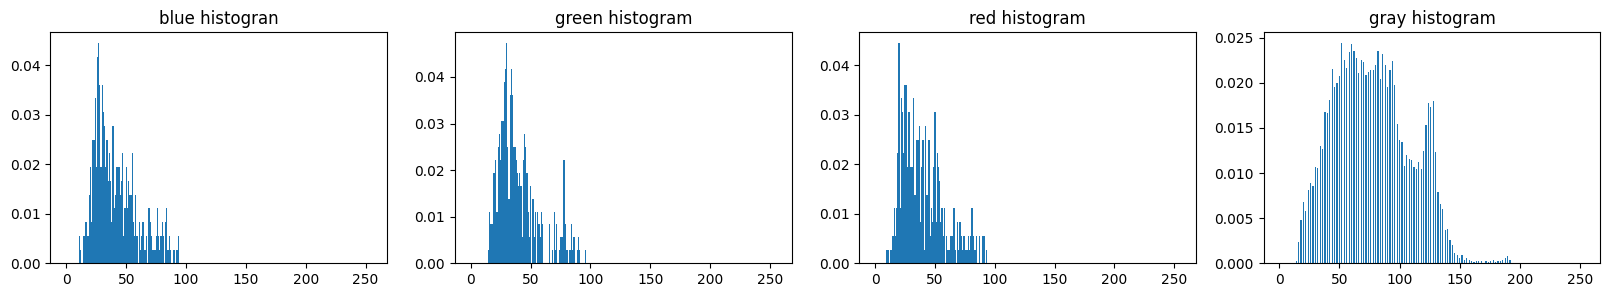

In [6]:
def norm_hist(hist):
    # Normalize the histogram
    hist = hist.astype('float')
    hist /= hist.sum()
    return hist

# color histogram
hist_b, bins_b = np.histogram(image[0], bins=256, range=(0, 256))
hist_g, bins_g = np.histogram(image[1], bins=256, range=(0, 256))
hist_r, bins_r = np.histogram(image[2], bins=256, range=(0, 256))
hist_b = norm_hist(hist_b)    # 256-d의 histogram feature를 뽑음
hist_g = norm_hist(hist_g)    # 256-d
hist_r = norm_hist(hist_r)    # 256-d

# gray histogram
hist_gray, bins_gray = np.histogram(gray, bins=128, range=(0, 256))
hist_gray = norm_hist(hist_gray)    # 128-d 여기선 128차원으로 설정. 내마음대로.

# visualization
plt.figure(figsize=(20, 3))

plt.subplot(1, 4, 1)
plt.title('blue histogran')
plt.bar(bins_b[:-1], hist_b, width=1)

plt.subplot(1, 4, 2)
plt.title('green histogram')
plt.bar(bins_g[:-1], hist_g, width=1)

plt.subplot(1, 4, 3)
plt.title('red histogram')
plt.bar(bins_r[:-1], hist_r, width=1)

plt.subplot(1, 4, 4)
plt.title('gray histogram')
plt.bar(bins_gray[:-1], hist_gray, width=1)

### LBP

<BarContainer object of 64 artists>

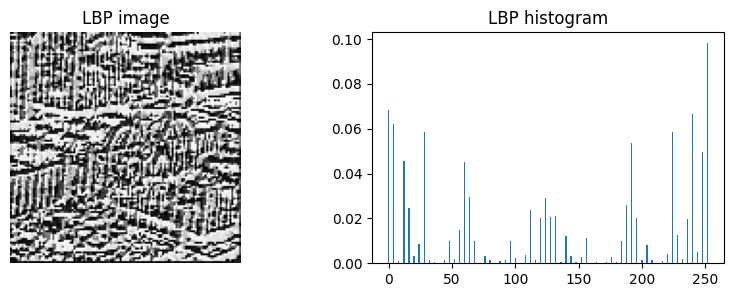

In [7]:
from skimage.feature import local_binary_pattern

# LBP
lbp = local_binary_pattern(gray, P=8, R=1)  # 주의 8개의 픽셀 고려 -> 8bit의 feature값을 추출

hist_lbp, bin_lbp = np.histogram(lbp.ravel(), bins=64, range=(0, 256))
hist_lbp = norm_hist(hist_lbp)    # 64-d

# visualization
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('LBP image')
plt.axis('off')
plt.imshow(lbp, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('LBP histogram')
plt.bar(bin_lbp[:-1], hist_lbp, width=1)

### GLCM

In [8]:
# GLCM
from skimage.feature import graycomatrix, graycoprops

glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=False, normed=True)

max_prob = np.max(glcm)
contrast = graycoprops(glcm, 'contrast')
dissimilarity = graycoprops(glcm, 'dissimilarity')
homogeneity = graycoprops(glcm, 'homogeneity')
energy = graycoprops(glcm, 'energy')
correlation = graycoprops(glcm, 'correlation')

print('Max probability:', max_prob)
print('Contrast:', contrast[0][0])
print('Dissimilarity:', dissimilarity[0][0])
print('Homogeneity:', homogeneity[0][0])
print('Energy:', energy[0][0])
print('Correlation:', correlation[0][0])
# 이 6가지 값이 glcm의 6차원 feature

Max probability: 0.002240896358543417
Contrast: 184.04964985994397
Dissimilarity: 9.225840336134455
Homogeneity: 0.1607216027232011
Energy: 0.019046589196084266
Correlation: 0.9078959515410305


In [9]:
'''
    i j
'''
glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=False, normed=True)

'''
    i
    j
'''
glcm = graycomatrix(gray, distances=[1], angles=[np.pi/2], levels=256, symmetric=False, normed=True)

'''
    i
      j
'''
glcm = graycomatrix(gray, distances=[1], angles=[np.pi/4], levels=256, symmetric=False, normed=True)

### Law's texture

In [10]:
# Law's texture
from scipy import signal as sg

def laws_texture(gray):
    (rows, cols) = gray.shape[:2]

    smooth_kernel = (1/25)*np.ones((5,5))
    gray_smooth = sg.convolve(gray, smooth_kernel,"same")
    gray_processed = np.abs(gray - gray_smooth)

    filter_vectors = np.array([[ 1,  4,  6,  4, 1],    # L5
                               [-1, -2,  0,  2, 1],    # E5
                               [-1,  0,  2,  0, 1],    # S5
                               [ 1, -4,  6, -4, 1]])   # R5

    # 0:L5L5, 1:L5E5, 2:L5S5, 3:L5R5,
    # 4:E5L5, 5:E5E5, 6:E5S5, 7:E5R5,
    # 8:S5L5, 9:S5E5, 10:S5S5, 11:S5R5,
    # 12:R5L5, 13:R5E5, 14:R5S5, 15:R5R5
    filters = list()
    for i in range(4):
        for j in range(4):
            filters.append(np.matmul(filter_vectors[i][:].reshape(5,1),
                                     filter_vectors[j][:].reshape(1,5)))

    conv_maps = np.zeros((rows, cols,16))
    for i in range(len(filters)):
        conv_maps[:, :, i] = sg.convolve(gray_processed,
                                         filters[i],'same')

	# 여기서는 가장 중요한 9가지만 골라 사용했음.
    texture_maps = list()
    texture_maps.append((conv_maps[:, :, 1]+conv_maps[:, :, 4])//2)     # L5E5 / E5L5
    texture_maps.append((conv_maps[:, :, 2]+conv_maps[:, :, 8])//2)     # L5S5 / S5L5
    texture_maps.append((conv_maps[:, :, 3]+conv_maps[:, :, 12])//2)    # L5R5 / R5L5
    texture_maps.append((conv_maps[:, :, 7]+conv_maps[:, :, 13])//2)    # E5R5 / R5E5
    texture_maps.append((conv_maps[:, :, 6]+conv_maps[:, :, 9])//2)     # E5S5 / S5E5
    texture_maps.append((conv_maps[:, :, 11]+conv_maps[:, :, 14])//2)   # S5R5 / R5S5
    texture_maps.append(conv_maps[:, :, 10])                            # S5S5
    texture_maps.append(conv_maps[:, :, 5])                             # E5E5
    texture_maps.append(conv_maps[:, :, 15])                            # R5R5
    texture_maps.append(conv_maps[:, :, 0])                             # L5L5 (use to norm TEM)

    TEM = list()
    for i in range(9):
        TEM.append(np.abs(texture_maps[i]).sum() / np.abs(texture_maps[9]).sum())

    return TEM

laws = laws_texture(gray)    # 9-d
print(laws)

[0.06405685782420119, 0.1268513550229604, 0.12794970496351235, 0.031271688435861714, 0.013639978898129507, 0.026063367594507274, 0.01917102946493686, 0.02240868564329823, 0.05689975125547207]


### SIFT

22


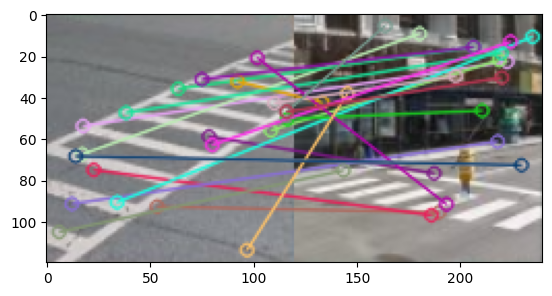

In [11]:
image1 = cv2.imread('./recaptcha-dataset/Large/Crosswalk/Cross (2).png')
image2 = cv2.imread('./recaptcha-dataset/Large/Crosswalk/Cross (5).png')

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1, None)    # des: (n, 128)
kp2, des2 = sift.detectAndCompute(image2, None)    # des: (n, 128)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1,des2)
print(len(matches))
matches = sorted(matches, key = lambda x:x.distance)
image3 = cv2.drawMatches(image1,kp1,image2,kp2,matches[:],None,flags=2)
plt.imshow(image3)
plt.show()

### HoG

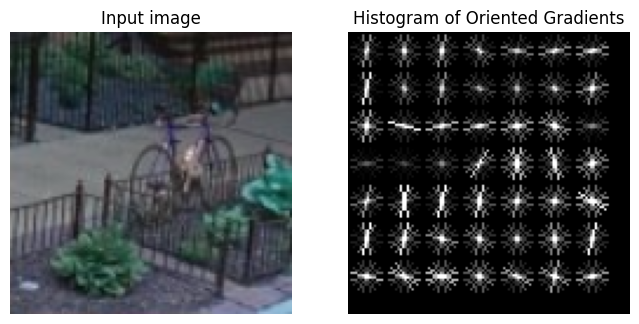

In [12]:
from skimage.feature import hog
from skimage import data, exposure

# Extract HoG features
# fd: 8 * (image.shape[0]//16)*(image.shape[1]//16) dimension
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

# Visualize HoG image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap='gray')
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

recaptcha = './recaptcha-dataset/Large'
labels = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney',
          'Crosswalk', 'Hydrant', 'Motorcycle', 'Palm', 'Traffic Light']

train_features = []
train_labels = []
test_features = []
test_labels = []

for label in labels:
    image_dir = os.path.join(recaptcha, label)
    image_list = os.listdir(image_dir)
    for i, image_name in enumerate(image_list):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

		# 빨리 하려고 제약 넣음. 구현할 때는 제거
        if i < 10:
            # laws_texture 하나만 사용했음
            train_features.append(laws_texture(gray_img))
            train_labels.append(label)
        elif 10 <= i < 20:
            test_features.append(laws_texture(gray_img))
            test_labels.append(label)
        else:
            break

classifier = KNeighborsClassifier(n_neighbors = 3)

classifier.fit(train_features, train_labels)
predict_labels = classifier.predict(test_features)
print(classification_report(test_labels, predict_labels))

               precision    recall  f1-score   support

      Bicycle       0.33      0.40      0.36        10
       Bridge       0.07      0.20      0.10        10
          Bus       0.25      0.10      0.14        10
          Car       0.07      0.10      0.08        10
      Chimney       0.11      0.10      0.11        10
    Crosswalk       0.20      0.10      0.13        10
      Hydrant       0.12      0.20      0.15        10
   Motorcycle       0.38      0.30      0.33        10
         Palm       0.00      0.00      0.00        10
Traffic Light       0.00      0.00      0.00        10

     accuracy                           0.15       100
    macro avg       0.15      0.15      0.14       100
 weighted avg       0.15      0.15      0.14       100



### Task 1: Classification

In [14]:
predict_labels = classifier.predict(test_features)
print(predict_labels)    # array(100)

['Bicycle' 'Bridge' 'Car' 'Car' 'Bicycle' 'Motorcycle' 'Bicycle' 'Bridge'
 'Bicycle' 'Car' 'Crosswalk' 'Chimney' 'Hydrant' 'Chimney' 'Bicycle'
 'Crosswalk' 'Bridge' 'Hydrant' 'Crosswalk' 'Bridge' 'Bridge' 'Bridge'
 'Hydrant' 'Bridge' 'Chimney' 'Crosswalk' 'Car' 'Hydrant' 'Car' 'Bus'
 'Hydrant' 'Motorcycle' 'Car' 'Bridge' 'Hydrant' 'Bridge' 'Bridge'
 'Hydrant' 'Chimney' 'Bridge' 'Bus' 'Bridge' 'Bridge' 'Car' 'Car'
 'Motorcycle' 'Chimney' 'Bus' 'Hydrant' 'Car' 'Hydrant' 'Bicycle' 'Bridge'
 'Bridge' 'Hydrant' 'Hydrant' 'Car' 'Crosswalk' 'Bicycle' 'Bicycle'
 'Traffic Light' 'Car' 'Car' 'Hydrant' 'Chimney' 'Car' 'Motorcycle'
 'Hydrant' 'Bridge' 'Motorcycle' 'Car' 'Bicycle' 'Bus' 'Motorcycle'
 'Motorcycle' 'Hydrant' 'Bridge' 'Motorcycle' 'Car' 'Chimney' 'Hydrant'
 'Bridge' 'Bridge' 'Bridge' 'Bicycle' 'Bridge' 'Bridge' 'Hydrant'
 'Chimney' 'Bridge' 'Bridge' 'Bridge' 'Palm' 'Bicycle' 'Bridge' 'Bridge'
 'Chimney' 'Bridge' 'Bridge' 'Bicycle']


In [15]:
import csv

with open('c1_t1_a1.csv','w') as file:
    write = csv.writer(file)
    for i, predict_label in enumerate(predict_labels):
        write.writerow([f'query{i+1:03}.png', predict_label])

### Task 2: Retrieval

In [16]:
neigh_ind = classifier.kneighbors(X=test_features, n_neighbors=10, return_distance=False) # Top-10 results
neigh_labels = np.array(train_labels)[neigh_ind]  # 인덱스를 제출하는 것이 아니라 label을 제출하는 것이기 때문

In [17]:
print(neigh_labels)    # array(100x10)

[['Car' 'Bicycle' 'Chimney' 'Car' 'Bus' 'Bus' 'Crosswalk' 'Hydrant'
  'Crosswalk' 'Car']
 ['Traffic Light' 'Bridge' 'Bridge' 'Car' 'Palm' 'Motorcycle' 'Chimney'
  'Crosswalk' 'Palm' 'Bus']
 ['Hydrant' 'Crosswalk' 'Car' 'Hydrant' 'Bicycle' 'Bus' 'Bridge'
  'Hydrant' 'Motorcycle' 'Car']
 ['Car' 'Bicycle' 'Car' 'Crosswalk' 'Chimney' 'Bicycle' 'Bicycle' 'Bus'
  'Car' 'Crosswalk']
 ['Bicycle' 'Motorcycle' 'Palm' 'Motorcycle' 'Car' 'Hydrant' 'Hydrant'
  'Bicycle' 'Motorcycle' 'Motorcycle']
 ['Motorcycle' 'Bicycle' 'Motorcycle' 'Bicycle' 'Car' 'Car' 'Bus'
  'Motorcycle' 'Bicycle' 'Hydrant']
 ['Bus' 'Motorcycle' 'Bicycle' 'Bicycle' 'Car' 'Motorcycle' 'Motorcycle'
  'Car' 'Bus' 'Bicycle']
 ['Car' 'Bridge' 'Motorcycle' 'Palm' 'Motorcycle' 'Hydrant' 'Motorcycle'
  'Bicycle' 'Bicycle' 'Motorcycle']
 ['Bus' 'Bicycle' 'Bicycle' 'Bicycle' 'Car' 'Motorcycle' 'Bicycle' 'Bus'
  'Bicycle' 'Car']
 ['Crosswalk' 'Chimney' 'Car' 'Chimney' 'Traffic Light' 'Crosswalk'
  'Bicycle' 'Car' 'Palm' 'Bridge']
 ['Cros

In [18]:
import csv

with open('c1_t2_a1.csv','w') as file :
    write = csv.writer(file)
    for i, neigh_label in enumerate(neigh_labels):
        write.writerow([f'query{i+1:03}.png'] + list(neigh_label))